In [534]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from control import *
from control import matlab

In [535]:
r1 = 10E3
r2 = 15E3
c1 = 1E-6
c2 = 1E-6

In [536]:
# Crea el operador diferencial S que se utiliza en las funciones transferencia
s = tf('s')

# Funcion transferencia de la planta en el tiempo continuo
h_s = 1 / (1 + r1*c1*r2*c2*s*s + (r1*c1 + r1*c2 + r2*c2)*s)
# h_s = (0.2*s+1) / (0.1*s*s + 0.4*s +1 )
h_s

# Se tienen los coeficientes
num, den = tfdata(h_s)
print(num,den)
# Se pasa a espacio de estados
h_ss = tf2ss(num,den)

[[array([1])]] [[array([1.5e-04, 3.5e-02, 1.0e+00])]]


In [537]:
# Se define el periodo de muestreo
h = 0.0001

# Se discretiza la planta
# matlab.c2d(Funcion transferencia continua, periodo de muestreo, tipo de retardo)
hz = matlab.c2d(h_s, h, 'zoh')
hz
# Obtengo numerado y denominador de la funcion transferencia
numz, denz = tfdata(hz)

# Ecuacion en espacio de estados
h_sz = tf2ss(hz)

In [538]:
# Se obtiene polos y ceros en tiempo discreto
# polosz, cerosz = pzmap(hz)[0]

# Se obtiene polos y ceros en tiempo continuo
# polosc, cerosc = pzmap(h_s)[0]

Text(0, 0.5, 'Amplitud (v)')

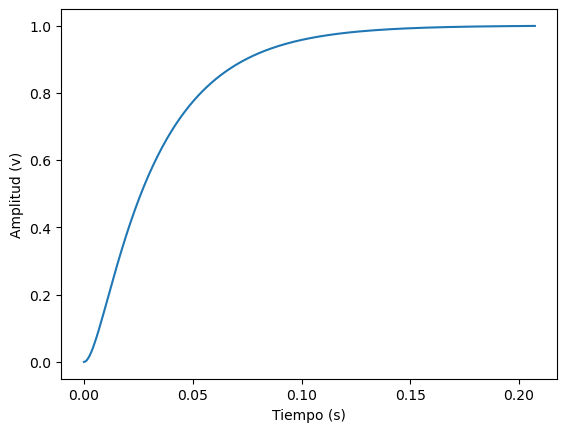

In [539]:
# Se evalua la respuesta al escalon en el tiempo continuo
t, out = step_response(h_s)
plt.plot(t, out)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (v)")

In [540]:
# Calcular tiempo de subida
def tiempo_de_subida(t, y):
    y_final = y[-1]
    y_10 = 0.1 * y_final
    y_90 = 0.9 * y_final

    t_10 = next(t[i] for i in range(len(y)) if y[i] >= y_10)
    t_90 = next(t[i] for i in range(len(y)) if y[i] >= y_90)

    return t_90 - t_10

# Calcular el tiempo de subida
tr = tiempo_de_subida(t, out) * 1000
print(f"Tiempo de subida: {tr:.2f}ms")

Tiempo de subida: 66.78ms


Tiempo de subida: 67.50ms


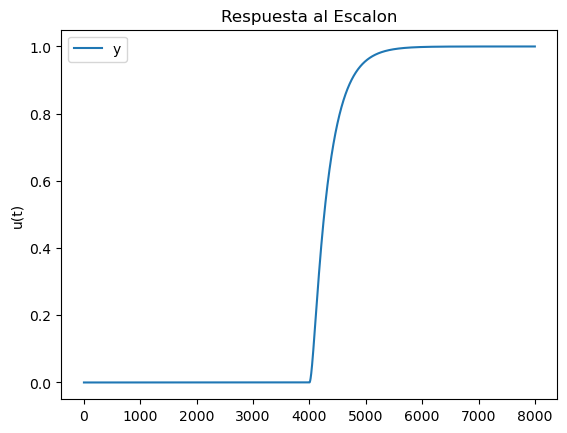

In [541]:
# Respuesta al escalon el tiempo discreto
t = np.linspace(h, h * 8000, 8000)
u = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None)

t_hz_1, y_hz_1 = forced_response(hz, t, u)

p_1 = plt.plot(y_hz_1)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend('y(t)')

# Calcular el tiempo de subida
tr = tiempo_de_subida(t, y_hz_1) * 1000
print(f"Tiempo de subida: {tr:.2f}ms")

In [542]:
def find_fodt_parameters_and_tangent(t, y):
    y_final = y[-1]
    K = y_final  # Ganancia estática
    dydt = np.diff(y) / np.diff(t)
    max_slope_idx = np.argmax(dydt)
    L = t[max_slope_idx]  # Aproximación del tiempo de retardo
    T = (y[-1] - y[0]) / dydt[max_slope_idx]  # Aproximación de la constante de tiempo
    
    # Punto de máxima pendiente
    t_max_slope = t[max_slope_idx]
    y_max_slope = y[max_slope_idx]
    slope = dydt[max_slope_idx]
    
    # Ecuación de la tangente: y_tangent = slope * (t - t_max_slope) + y_max_slope
    t_tangent = np.linspace(0, t[-1], 8000)
    y_tangent = slope * (t_tangent - t_max_slope) + y_max_slope
    
    return K, L, T, t_max_slope, y_max_slope, t_tangent, y_tangent

# t_coef = t = np.linspace(h/8000, h/8000 * 8000, 8000)
K, L, T, t_max_slope, y_max_slope, t_tangent, y_tangent = find_fodt_parameters_and_tangent(t, y_hz_1)
K, L,T

(0.9999980499945645, 0.4108, 0.04292910802930415)

In [543]:
Lprima = L + h/2
Kp = 1.2 * T / Lprima
Ti = 2 * Lprima
Td = 0.5 * Lprima

print(f"Parámetros del controlador PID según Ziegler-Nichols:")
print(f"Kp: {Kp:.4f}")
print(f"Ti: {Ti:.4f}")
print(f"Td: {Td:.4f}")

Parámetros del controlador PID según Ziegler-Nichols:
Kp: 0.1254
Ti: 0.8217
Td: 0.2054


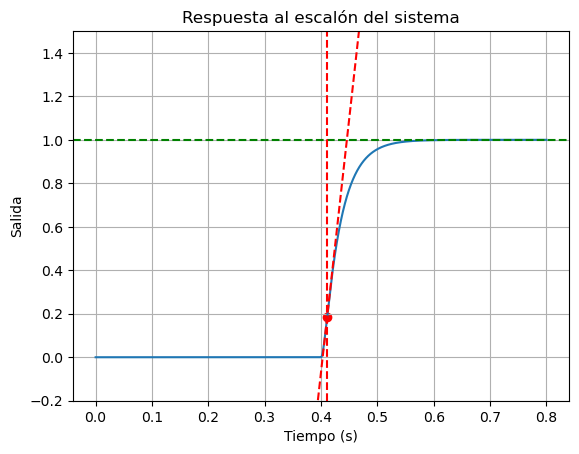

In [544]:
plt.plot(t, y_hz_1, label='Respuesta al escalón')
plt.plot(t_tangent, y_tangent, 'r--', label='Tangente en la máxima pendiente')
plt.axhline(K, color='g', linestyle='--', label=f'K = {K:.4f}')
plt.axvline(L, color='r', linestyle='--', label=f'L = {L:.4f}')
plt.scatter([t_max_slope], [y_max_slope], color='red')  # Punto de máxima pendiente
plt.xlabel('Tiempo (s)')
plt.ylabel('Salida')
plt.title('Respuesta al escalón del sistema')
plt.ylim([-0.2, 1.5])  # Ajustar los límites del eje Y para una mejor visualización
# plt.legend()
plt.grid(True)

In [545]:
# Funciones para el control PID

def pid_controller(pid_data: dict) -> dict:
    
    data = pid_data.copy()
    
    p = data['kp'] * (data['b'] * data['r'] - data['y'])
    i = data['future_i']
    d = (data['kd'] / (data['kd'] + data['n'] * data['h'])) * (data['past_d'] - data['n'] * (data['y'] - data['past_y']))
    
    data['u'] = p + i + d
    
    data['future_i'] = i + data['ki'] * data['h'] * (data['r'] - data['y'])
    data['past_d'] = d
    data['past_y'] = data['y']
    
    return data

def pid_controller_response(num: np.ndarray, den: np.ndarray, input: np.ndarray, pid_data: dict) -> np.ndarray:
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()
    
    n_inicial = len(a) - 1
    
    y = np.zeros(len(input) + n_inicial)
    r = np.concatenate((np.zeros(n_inicial), input), axis=None)
    u = np.concatenate((np.zeros(n_inicial), input), axis=None)
    
    data = pid_data.copy()
    
    for k in range(n_inicial, len(r)):

      data['y'] = y[k-1]
      data['r'] = r[k]

      data = pid_controller(data)
    
      u[k] = data['u']

      for m in range(0, len(b)):
        y[k] = y[k] + b[m] * u[k-m]
      
      for n in range(1, len(a)):
        y[k] = y[k] - a[n] * y[k-n]
    
      y[k] = y[k] / a[0]
    
    return y[n_inicial-1:]

10
10 0.1 100.0
10 0.2 2.0
Tiempo de subida: 2.70ms
Sobrepico: -53.19%


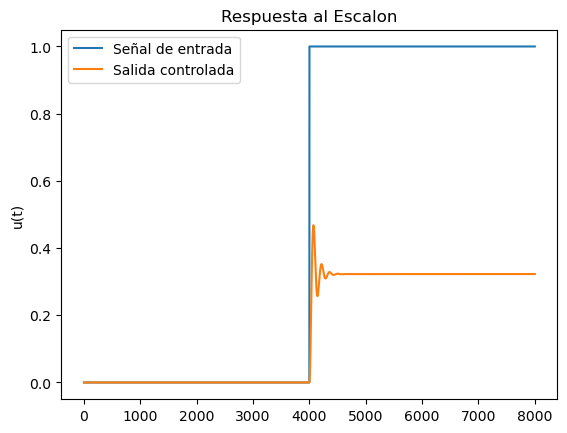

In [546]:
r = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None)

pid_data = dict()

Kp = 10
Ti = 0.1
Td = 0.2

pid_data['kp'] = Kp 
print(Kp)

# Ki = Kp / Ti
pid_data['ki'] = h*(Kp/Ti)
print(Kp, Ti, Kp/Ti)

# Kd = Kp * Td
pid_data['kd'] = Kp*Td/h
print(Kp, Td, Kp*Td)

pid_data['h'] = h
pid_data['n'] = 20
pid_data['b'] = 1

pid_data['future_i'] = 0
pid_data['past_d'] = 0
pid_data['past_y'] = 0

y_hz_pid = pid_controller_response(numz, denz, r, pid_data)

p_1 = plt.plot(r)
p_2 = plt.plot(y_hz_pid)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend((p_1[0], p_2[0]), ('Señal de entrada', 'Salida controlada'))

maxpoint = np.max(y_hz_pid)
sobrepico = maxpoint - np.max(r)

# Calcular el tiempo de subida
tr = tiempo_de_subida(t, y_hz_pid) * 1000
print(f"Tiempo de subida: {tr:.2f}ms")
print(f"Sobrepico: {sobrepico*100:.2f}%")

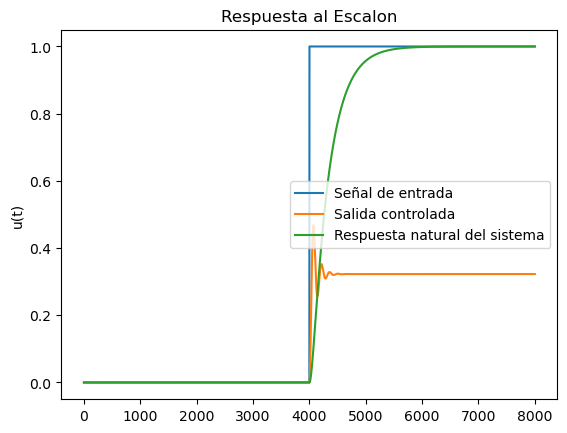

In [547]:
p_1 = plt.plot(r)
p_2 = plt.plot(y_hz_pid)
p_3 = plt.plot(y_hz_1)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend((p_1[0], p_2[0], p_3[0]), ('Señal de entrada', 'Salida controlada', 'Respuesta natural del sistema'));

In [548]:
import math

def resolver_ecuacion_cuadratica(a, b, c):
    # Calcula el discriminante
    discriminante = b**2 - 4*a*c
    
    # Verifica si el discriminante es positivo, negativo o cero
    if discriminante > 0:
        raiz1 = (-b + math.sqrt(discriminante)) / (2*a)
        raiz2 = (-b - math.sqrt(discriminante)) / (2*a)
        return (raiz1, raiz2)
    elif discriminante == 0:
        raiz = -b / (2*a)
        return (raiz,)
    else:
        # Para soluciones complejas
        parte_real = -b / (2*a)
        parte_imaginaria = math.sqrt(-discriminante) / (2*a)
        raiz1 = complex(parte_real, parte_imaginaria)
        raiz2 = complex(parte_real, -parte_imaginaria)
        return (raiz1, raiz2)

# Ejemplo de uso
a = 1
b = 6
c = 22.96
soluciones = resolver_ecuacion_cuadratica(a, b, c)
print(f"Las soluciones de la ecuación son: {soluciones}")

Las soluciones de la ecuación son: ((-3+3.736308338453881j), (-3-3.736308338453881j))


In [549]:
# DISEÑO DE PID A PARTIR DE ASIGNACION DE POLOS

print(numz)
k = numz[0][0][0]
a = denz[0][0][1]
b = denz[0][0][2]

print(k,a,b)

Mp = 8 # Asigna aquí el valor correspondiente a Mp
ep = np.sqrt(((np.log(Mp / 100))**2) / (np.pi**2 + (np.log(Mp / 100))**2))

# Asigna aquí el valor correspondiente a d y ep
d = denz[0][0]
print(d)
# Calcula las raíces del polinomio
roots = np.roots(d)

# Encuentra el valor absoluto del polo dominante
tau = 1 / np.abs(np.max(roots))

# Calcula el tiempo de establecimiento
Tss = (tau * 4) * 0.75

# Calcula la frecuencia natural
Wn = 3 / (ep * Tss)

# Imprime los resultados
print(f"tau: {tau}")
print(f"Tss: {Tss}")
print(f"Wn: {Wn}")

[[array([3.30753959e-05, 3.28191411e-05])]]
3.3075395923232165e-05 -1.9768708893612785 0.9769367838983475
[ 1.         -1.97687089  0.97693678]
tau: 1.0033388950668782
Tss: 3.0100166852006347
Wn: 1.590661512998402


In [550]:
# Calcular los polos dominantes
Sd = np.array([-ep * Wn + 1j * Wn * np.sqrt(1 - ep**2),
               -ep * Wn - 1j * Wn * np.sqrt(1 - ep**2)])

# Definir el polo no dominante
p3 = np.real(Sd[0]) * 10  # Polo no dominante 20 veces más lejos que el dominante

# Combinar los polos dominantes y no dominantes
Sd1 = np.append(Sd, p3)

# Calcular el polinomio a partir de los polos
Pds = np.poly(Sd1)

print("Pds:", Pds)

Pds: [ 1.         11.96006659 22.39731417 25.21784077]


In [551]:
# Distancia inicial del polo
disP = 10

# Calcular los parámetros del controlador
Kc = (Pds[2] - b) / k
ti = (k * Kc) / Pds[3]
td = (Pds[1] - a) / (k * Kc)

# Parámetros del PID con filtro en el término derivativo
alpha = 0.1  # Por ejemplo, ajusta según sea necesario
d2 = alpha * Kc * ti * td + Kc * ti * td
d1 = Kc * ti + alpha * Kc * td
d0 = Kc

# Controlador PID
num = [d2, d1, d0]
den = [alpha * ti * td, ti, 0]
C = signal.TransferFunction(num, den)

# Calcular N
N = 1 / (td * alpha)

# Simulación con el modelo en lazo cerrado
H = signal.TransferFunction([1], [1])  # Modelo en lazo abierto
# Multiplicar C y P, luego sumar 1 a la salida para obtener H
H_num = np.convolve(C.num[0], P.num)
H_den = np.convolve(C.den, P.den) + H_num
H.num, H.den = signal.tfnormalize(H_num, H_den)

# Obtener la respuesta al escalón
t, y = signal.step(H)

# Graficar la respuesta al escalón
plt.figure()
plt.plot(t, y)
plt.title('Respuesta al escalón')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.grid(True)

# Diagrama de polos y ceros
plt.figure()
plt.plot(np.real(H.zeros), np.imag(H.zeros), 'o', label='Ceros')
plt.plot(np.real(H.poles), np.imag(H.poles), 'x', label='Polos')
plt.title('Diagrama de polos y ceros')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend()
plt.grid(True)


NameError: name 'P' is not defined